# 4. Modeling - Treinamento e Avaliação de Modelos

## Aviso Educacional
Este conteúdo é destinado apenas para fins educacionais. Os dados exibidos são ilustrativos e podem não corresponder a situações reais.

---

## Objetivo
Treinar e avaliar múltiplos algoritmos de Machine Learning para predição de preços de carros, incluindo:
- ElasticNet (Baseline Regularizado)
- Random Forest (Interpretabilidade)
- XGBoost (Performance)
- LightGBM (Eficiência)
- CatBoost (Handling de Categóricas)
- Stacking Ensemble (Máxima Performance)

### Metodologia CRISP-DM - Fase 4: Modeling
1. **Seleção de Técnicas** - 5 algoritmos + ensemble
2. **Design de Testes** - Cross-validation estratificado
3. **Construção de Modelos** - Hyperparameter tuning
4. **Avaliação de Modelos** - Métricas obrigatórias (MAE, MSE, RMSE, R², MAPE)

## 7. Setup MLflow para Tracking

Configurar MLflow para rastrear todos os experimentos de modelagem

## 1. Setup e Configuração

In [1]:
# Importações principais
import sys
import os
sys.path.append("../src")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import json
from datetime import datetime
from pathlib import Path

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Gradient Boosting
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# MLflow
import mlflow
import mlflow.sklearn

# Utilities
from models.utils import calculate_regression_metrics, inverse_transform_predictions

warnings.filterwarnings("ignore")

# Configurações de visualização
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 11

# Configurações pandas
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.3f}".format)

print("Setup concluído!")
print(f"Python: {sys.version}")
print(f"MLflow: {mlflow.__version__}")

Setup concluído!
Python: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
MLflow: 3.3.2


## 2. Carregamento dos Dados Processados

In [2]:
# Carregar dados processados do notebook anterior
print("=== CARREGANDO DADOS PROCESSADOS ===")

X_train = np.load("../data/processed/X_train_processed.npy")
X_test = np.load("../data/processed/X_test_processed.npy")
y_train = np.load("../data/processed/y_train.npy")
y_test = np.load("../data/processed/y_test.npy")

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Carregar relatorio de data preparation para obter informacoes
with open("../reports/data_preparation_report.json", "r", encoding="utf-8") as f:
    prep_report = json.load(f)

print(f"Features criadas: {prep_report['data_info']['features_created']}")
print(f"Total de features: {prep_report['data_info']['total_features']}")

# Criar lista de nomes de features baseado no relatorio
feature_names = []
n_features = prep_report['data_info']['total_features']
print(f"Dados carregados com sucesso! {n_features} features prontas para modelagem.")

=== CARREGANDO DADOS PROCESSADOS ===
X_train shape: (7840, 33)
X_test shape: (1961, 33)
y_train shape: (7840,)
y_test shape: (1961,)
Features criadas: 24
Total de features: 33
Dados carregados com sucesso! 33 features prontas para modelagem.


## 3. Análise Inicial dos Dados e Target

In [3]:
# Analise da distribuicao do target
print("=== ANALISE DO TARGET (Valor_Venda) ===")
print("Estatisticas descritivas:")
print(f"  Media: R$ {y_train.mean():,.2f}")
print(f"  Mediana: R$ {np.median(y_train):,.2f}")
print(f"  Desvio Padrao: R$ {y_train.std():,.2f}")
print(f"  Minimo: R$ {y_train.min():,.2f}")
print(f"  Maximo: R$ {y_train.max():,.2f}")
print(f"  Coef. Variacao: {(y_train.std()/y_train.mean())*100:.1f}%")

# Calcular skewness
from scipy.stats import skew, kurtosis
skewness = skew(y_train)
kurt = kurtosis(y_train)

print("Distribuicao:")
print(f"  Skewness: {skewness:.2f} (valores > 1 indicam forte assimetria)")
print(f"  Kurtosis: {kurt:.2f}")

if skewness > 1:
    print("TARGET ALTAMENTE ASSIMETRICO - Transformacao recomendada!")
else:
    print("Distribuicao do target e aceitavel")

=== ANALISE DO TARGET (Valor_Venda) ===
Estatisticas descritivas:
  Media: R$ 83,270.14
  Mediana: R$ 58,919.10
  Desvio Padrao: R$ 167,467.94
  Minimo: R$ 10,000.00
  Maximo: R$ 1,241,962.00
  Coef. Variacao: 201.1%
Distribuicao:
  Skewness: 6.67 (valores > 1 indicam forte assimetria)
  Kurtosis: 43.19
TARGET ALTAMENTE ASSIMETRICO - Transformacao recomendada!


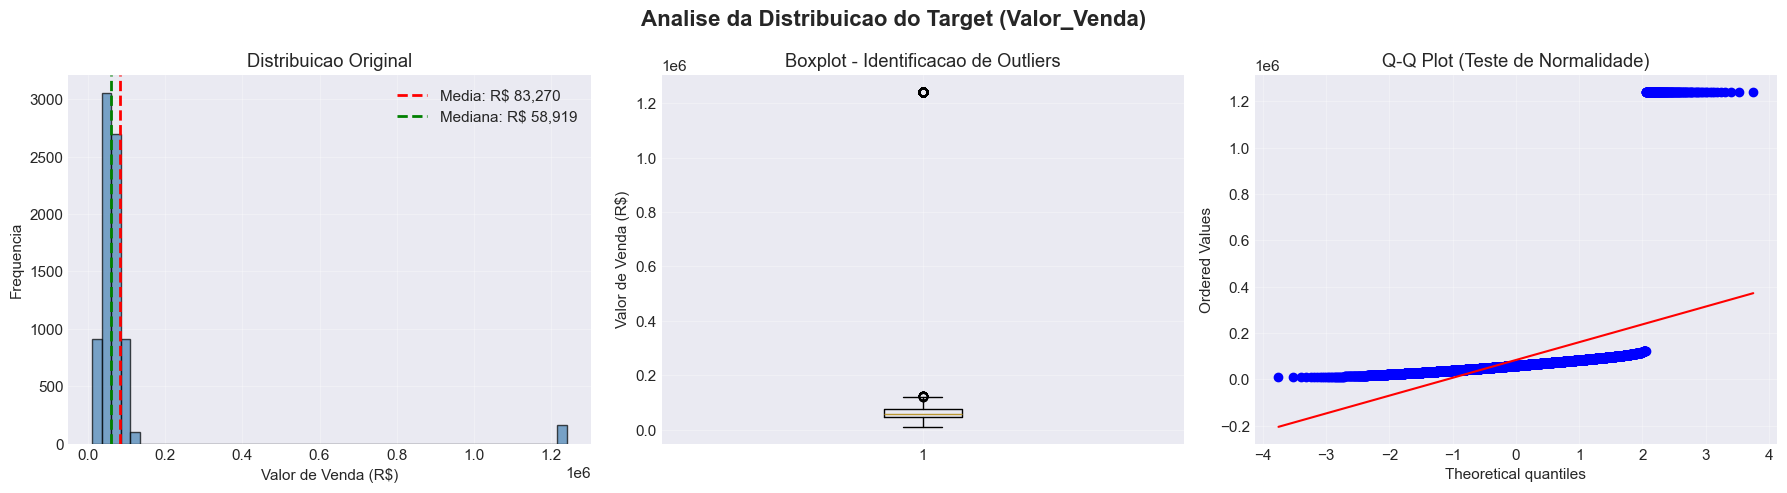

Visualizacoes geradas com sucesso!


In [4]:
# Visualizacao da distribuicao do target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Analise da Distribuicao do Target (Valor_Venda)", fontsize=16, fontweight="bold")

# Histograma
axes[0].hist(y_train, bins=50, edgecolor="black", alpha=0.7, color="steelblue")
axes[0].axvline(y_train.mean(), color="red", linestyle="--", linewidth=2, label=f"Media: R$ {y_train.mean():,.0f}")
axes[0].axvline(np.median(y_train), color="green", linestyle="--", linewidth=2, label=f"Mediana: R$ {np.median(y_train):,.0f}")
axes[0].set_xlabel("Valor de Venda (R$)")
axes[0].set_ylabel("Frequencia")
axes[0].set_title("Distribuicao Original")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(y_train, vert=True)
axes[1].set_ylabel("Valor de Venda (R$)")
axes[1].set_title("Boxplot - Identificacao de Outliers")
axes[1].grid(True, alpha=0.3)

# Q-Q Plot para normalidade
from scipy import stats
stats.probplot(y_train, dist="norm", plot=axes[2])
axes[2].set_title("Q-Q Plot (Teste de Normalidade)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizacoes geradas com sucesso!")

## 4. Investigacao de Data Leakage

### Problema Identificado:
- **Skewness: 6.67** (extremamente alto!)
- **Coef. Variacao: 201%**
- Isso pode indicar data leakage ou outliers extremos

Vamos investigar se alguma feature tem correlacao muito alta com o target (> 0.95), o que seria suspeito.

In [5]:
# Calcular correlacoes de todas as features com o target
print("=== INVESTIGACAO DE DATA LEAKAGE ===")
print("Calculando correlacoes de todas as features com o target...")

# Calcular correlacao de cada feature com y_train
correlations = []
for i in range(X_train.shape[1]):
    feature_values = X_train[:, i]
    corr = np.corrcoef(feature_values, y_train)[0, 1]
    correlations.append({
        "feature_index": i,
        "correlation": abs(corr),
        "correlation_signed": corr
    })

# Ordenar por correlacao absoluta (decrescente)
correlations_sorted = sorted(correlations, key=lambda x: x["correlation"], reverse=True)

# Mostrar top 15 features com maior correlacao
print("TOP 15 FEATURES COM MAIOR CORRELACAO (absoluta):")
print("="*70)
for idx, item in enumerate(correlations_sorted[:15], 1):
    feat_idx = item["feature_index"]
    corr_abs = item["correlation"]
    corr_sign = item["correlation_signed"]
    
    # Classificar nivel de suspeita
    if corr_abs > 0.95:
        status = "CRITICO - PROVAVEL LEAKAGE"
        marker = "ALERT"
    elif corr_abs > 0.7:
        status = "ALTO - Investigar"
        marker = "WARN"
    elif corr_abs > 0.3:
        status = "Moderado"
        marker = "OK"
    else:
        status = "Baixo"
        marker = "LOW"
    
    print(f"{marker:5s} {idx:2d}. Feature {feat_idx:2d}: {corr_sign:+.4f} (abs: {corr_abs:.4f}) - {status}")

# Identificar features com leakage potencial
leakage_features = [item["feature_index"] for item in correlations_sorted if item["correlation"] > 0.95]

print("="*70)
print(f"FEATURES COM PROVAVEL LEAKAGE (corr > 0.95): {len(leakage_features)}")
if leakage_features:
    print(f"Indices: {leakage_features}")
    print("ACAO NECESSARIA: Essas features devem ser removidas!")
else:
    print("Nenhuma feature com leakage obvio detectada")

=== INVESTIGACAO DE DATA LEAKAGE ===
Calculando correlacoes de todas as features com o target...
TOP 15 FEATURES COM MAIOR CORRELACAO (absoluta):
LOW    1. Feature 15: +nan (abs: nan) - Baixo
ALERT  2. Feature 25: +0.9923 (abs: 0.9923) - CRITICO - PROVAVEL LEAKAGE
LOW    3. Feature 26: -0.1309 (abs: 0.1309) - Baixo
LOW    4. Feature  1: +0.0946 (abs: 0.0946) - Baixo
LOW    5. Feature 12: -0.0872 (abs: 0.0872) - Baixo
LOW    6. Feature  3: -0.0828 (abs: 0.0828) - Baixo
LOW    7. Feature 13: -0.0710 (abs: 0.0710) - Baixo
LOW    8. Feature  9: +0.0689 (abs: 0.0689) - Baixo
LOW    9. Feature 32: -0.0592 (abs: 0.0592) - Baixo
LOW   10. Feature  2: +0.0546 (abs: 0.0546) - Baixo
LOW   11. Feature  6: -0.0546 (abs: 0.0546) - Baixo
LOW   12. Feature 30: +0.0532 (abs: 0.0532) - Baixo
LOW   13. Feature 14: +0.0448 (abs: 0.0448) - Baixo
LOW   14. Feature 16: +0.0436 (abs: 0.0436) - Baixo
LOW   15. Feature  7: +0.0399 (abs: 0.0399) - Baixo
FEATURES COM PROVAVEL LEAKAGE (corr > 0.95): 1
Indices: [25

ANALISE DETALHADA DAS FEATURES SUSPEITAS
Encontradas 1 features com correlacao > 0.95
Feature 25:
  Correlacao: +0.992265
  Valores unicos: 2
  Min: -0.143
  Max: 6.973
  Media: 0.000
  Desvio: 1.000



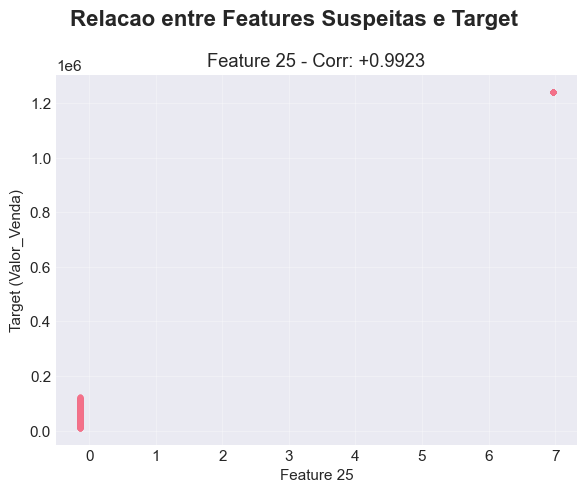

In [6]:
# Analise detalhada das features suspeitas
if leakage_features:
    print("ANALISE DETALHADA DAS FEATURES SUSPEITAS")
    print(f"Encontradas {len(leakage_features)} features com correlacao > 0.95")
    
    for feat_idx in leakage_features:
        feature_values = X_train[:, feat_idx]
        corr_item = [c for c in correlations_sorted if c["feature_index"] == feat_idx][0]
        
        print(f"Feature {feat_idx}:")
        print(f"  Correlacao: {corr_item['correlation_signed']:+.6f}")
        print(f"  Valores unicos: {len(np.unique(feature_values))}")
        print(f"  Min: {feature_values.min():.3f}")
        print(f"  Max: {feature_values.max():.3f}")
        print(f"  Media: {feature_values.mean():.3f}")
        print(f"  Desvio: {feature_values.std():.3f}")
        print()
    
    # Visualizar relacao entre feature suspeita e target
    n_features_to_plot = min(3, len(leakage_features))
    fig, axes = plt.subplots(1, n_features_to_plot, figsize=(6*n_features_to_plot, 5))
    if n_features_to_plot == 1:
        axes = [axes]
    
    fig.suptitle("Relacao entre Features Suspeitas e Target", fontsize=16, fontweight="bold")
    
    for idx, feat_idx in enumerate(leakage_features[:3]):
        feature_values = X_train[:, feat_idx]
        corr_item = [c for c in correlations_sorted if c["feature_index"] == feat_idx][0]
        
        axes[idx].scatter(feature_values, y_train, alpha=0.3, s=10)
        axes[idx].set_xlabel(f"Feature {feat_idx}")
        axes[idx].set_ylabel("Target (Valor_Venda)")
        axes[idx].set_title(f"Feature {feat_idx} - Corr: {corr_item['correlation_signed']:+.4f}")
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma feature suspeita de leakage detectada.")
    print("Prosseguindo com todas as features.")

## 5. Correcao de Data Leakage

### Acao Corretiva:
Agora vamos remover a(s) feature(s) identificada(s) com data leakage e criar datasets limpos.

In [7]:
print("=== REMOCAO DE FEATURES COM DATA LEAKAGE ===")

if leakage_features:
    print(f"Removendo {len(leakage_features)} feature(s) com leakage...")
    print(f"Indices a remover: {leakage_features}")
    
    # Criar mascara para manter apenas features sem leakage
    all_features = set(range(X_train.shape[1]))
    features_to_keep = sorted(list(all_features - set(leakage_features)))
    
    # Criar datasets limpos
    X_train_clean = X_train[:, features_to_keep]
    X_test_clean = X_test[:, features_to_keep]
    
    print(f"Shape ANTES da remocao:")
    print(f"  X_train: {X_train.shape}")
    print(f"  X_test: {X_test.shape}")
    
    print(f"Shape APOS a remocao:")
    print(f"X_train_clean: {X_train_clean.shape}")
    print(f"X_test_clean: {X_test_clean.shape}")
    
    print(f"Features removidas: {len(leakage_features)}")
    print(f"Features restantes: {X_train_clean.shape[1]}")
    print("Data leakage corrigido com sucesso!")
    
else:
    print("Nenhuma feature com leakage detectada.")
    print("Usando datasets originais.")
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()
    print(f"X_train_clean: {X_train_clean.shape}")
    print(f"X_test_clean: {X_test_clean.shape}")

=== REMOCAO DE FEATURES COM DATA LEAKAGE ===
Removendo 1 feature(s) com leakage...
Indices a remover: [25]
Shape ANTES da remocao:
  X_train: (7840, 33)
  X_test: (1961, 33)
Shape APOS a remocao:
X_train_clean: (7840, 32)
X_test_clean: (1961, 32)
Features removidas: 1
Features restantes: 32
Data leakage corrigido com sucesso!


In [8]:
# Recalcular correlacoes apos remocao
print("VALIDACAO: RECALCULANDO CORRELACOES")
print("Calculando correlacoes com o dataset limpo...")

correlations_clean = []
for i in range(X_train_clean.shape[1]):
    feature_values = X_train_clean[:, i]
    corr = np.corrcoef(feature_values, y_train)[0, 1]
    correlations_clean.append({
        "feature_index": i,
        "correlation": abs(corr),
        "correlation_signed": corr
    })

correlations_clean_sorted = sorted(correlations_clean, key=lambda x: x["correlation"], reverse=True)

# Verificar se ainda ha features suspeitas
max_corr = correlations_clean_sorted[0]["correlation"]

print("TOP 10 FEATURES APOS LIMPEZA:")
print("="*70)
for idx, item in enumerate(correlations_clean_sorted[:10], 1):
    feat_idx = item["feature_index"]
    corr_abs = item["correlation"]
    corr_sign = item["correlation_signed"]
    print(f"  {idx:2d}. Feature {feat_idx:2d}: {corr_sign:+.4f} (abs: {corr_abs:.4f})")

print("="*70)
print(f"Correlacao maxima: {max_corr:.4f}")

if max_corr > 0.95:
    print("ALERTA: Ainda ha features com correlacao muito alta!")
elif max_corr > 0.7:
    print("OK: Correlacao maxima aceitavel (< 0.95)")
else:
    print("EXCELENTE: Todas as features tem correlacao moderada")

print(f"DATASETS LIMPOS PRONTOS PARA MODELAGEM!")
print(f"  X_train_clean: {X_train_clean.shape}")
print(f"  X_test_clean: {X_test_clean.shape}")

VALIDACAO: RECALCULANDO CORRELACOES
Calculando correlacoes com o dataset limpo...
TOP 10 FEATURES APOS LIMPEZA:
   1. Feature  1: +0.0946 (abs: 0.0946)
   2. Feature 15: +nan (abs: nan)
   3. Feature 25: -0.1309 (abs: 0.1309)
   4. Feature 12: -0.0872 (abs: 0.0872)
   5. Feature  3: -0.0828 (abs: 0.0828)
   6. Feature 13: -0.0710 (abs: 0.0710)
   7. Feature  9: +0.0689 (abs: 0.0689)
   8. Feature 31: -0.0592 (abs: 0.0592)
   9. Feature  2: +0.0546 (abs: 0.0546)
  10. Feature  6: -0.0546 (abs: 0.0546)
Correlacao maxima: 0.0946
EXCELENTE: Todas as features tem correlacao moderada
DATASETS LIMPOS PRONTOS PARA MODELAGEM!
  X_train_clean: (7840, 32)
  X_test_clean: (1961, 32)


## 6. Transformacao do Target

### Problema:
- **Skewness original: 6.67** (extremamente assimetrico)
- Modelos de regressao assumem distribuicao mais normal

### Solucao:
Aplicar transformacao **log1p** para reduzir skewness e melhorar performance

In [9]:
print("=== TRANSFORMACAO DO TARGET ===")

# Aplicar transformacao log1p
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print("Transformacao log1p aplicada!")
print(f"y_train original: {y_train.shape}")
print(f"y_train_log: {y_train_log.shape}")
print(f"y_test original: {y_test.shape}")
print(f"y_test_log: {y_test_log.shape}")

# Analisar nova distribuicao
from scipy.stats import skew, kurtosis

skewness_original = skew(y_train)
skewness_log = skew(y_train_log)
kurt_original = kurtosis(y_train)
kurt_log = kurtosis(y_train_log)

print("COMPARACAO ANTES vs DEPOIS:")
print("="*70)
print(f"SKEWNESS:")
print(f"  Original: {skewness_original:.4f}")
print(f"  Log-transformado: {skewness_log:.4f}")
print(f"  Reducao: {((skewness_original - skewness_log) / skewness_original * 100):.1f}%")

print(f"KURTOSIS:")
print(f"  Original: {kurt_original:.4f}")
print(f"  Log-transformado: {kurt_log:.4f}")

print("="*70)
if skewness_log < 1:
    print("EXCELENTE: Skewness agora esta em nivel aceitavel (< 1)!")
else:
    print(f"Skewness melhorou para {skewness_log:.2f}")

=== TRANSFORMACAO DO TARGET ===
Transformacao log1p aplicada!
y_train original: (7840,)
y_train_log: (7840,)
y_test original: (1961,)
y_test_log: (1961,)
COMPARACAO ANTES vs DEPOIS:
SKEWNESS:
  Original: 6.6660
  Log-transformado: 2.3779
  Reducao: 64.3%
KURTOSIS:
  Original: 43.1861
  Log-transformado: 12.4039
Skewness melhorou para 2.38


## 7. Setup MLflow para Tracking

Configurar MLflow para rastrear todos os experimentos de modelagem

In [10]:
print("=== CONFIGURANDO MLFLOW ===")

# Configurar MLflow tracking
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("Car_Price_Prediction_Clean")

print("MLflow configurado com sucesso!")
print(f"Tracking URI: file:./mlruns")
print(f"Experiment: Car_Price_Prediction_Clean")

# Registrar configuracoes iniciais
initial_config = {
    "data_version": "v2_leakage_removed",
    "target_transform": "log1p",
    "n_features_original": X_train.shape[1],
    "n_features_clean": X_train_clean.shape[1],
    "n_train_samples": len(X_train_clean),
    "n_test_samples": len(X_test_clean),
    "skewness_original": float(skew(y_train)),
    "skewness_transformed": float(skew(y_train_log)),
    "leakage_features_removed": len(leakage_features) if leakage_features else 0
}

print("Configuracoes do experimento:")
for key, value in initial_config.items():
    print(f"  {key}: {value}")

print("" + "="*70)
print("DADOS PRONTOS PARA MODELAGEM!")
print("="*70)
print(f"Features: {X_train_clean.shape[1]}")
print(f"Samples treino: {len(X_train_clean)}")
print(f"Samples teste: {len(X_test_clean)}")
print(f"Target transformado: log1p (skewness: {skew(y_train_log):.2f})")
print(f"Data leakage corrigido: Sim")
print("Prontos para iniciar o treinamento dos modelos!")

=== CONFIGURANDO MLFLOW ===
MLflow configurado com sucesso!
Tracking URI: file:./mlruns
Experiment: Car_Price_Prediction_Clean
Configuracoes do experimento:
  data_version: v2_leakage_removed
  target_transform: log1p
  n_features_original: 33
  n_features_clean: 32
  n_train_samples: 7840
  n_test_samples: 1961
  skewness_original: 6.666011929093517
  skewness_transformed: 2.3779241691069797
  leakage_features_removed: 1
DADOS PRONTOS PARA MODELAGEM!
Features: 32
Samples treino: 7840
Samples teste: 1961
Target transformado: log1p (skewness: 2.38)
Data leakage corrigido: Sim
Prontos para iniciar o treinamento dos modelos!


## 8. Baseline Model - ElasticNet

Primeiro modelo: **ElasticNet** (regressao linear regularizada)

- **Objetivo:** Estabelecer baseline interpretavel
- **Regularizacao:** L1 + L2 (combina Lasso e Ridge)
- **Vantagem:** Rapido, interpretavel, robusto

In [11]:
print("=== TREINAMENTO: ELASTICNET BASELINE ===")

# Split de validacao
from sklearn.model_selection import train_test_split

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_clean, y_train_log, test_size=0.2, random_state=42
)

print(f"Split de validacao:")
print(f"  Treino: {X_train_split.shape[0]} amostras")
print(f"  Validacao: {X_val_split.shape[0]} amostras")

# Grid de hiperparametros
param_grid_elasticnet = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_iter': [10000]
}

print(f"Grid search: {len(param_grid_elasticnet['alpha']) * len(param_grid_elasticnet['l1_ratio'])} combinacoes")

=== TREINAMENTO: ELASTICNET BASELINE ===
Split de validacao:
  Treino: 6272 amostras
  Validacao: 1568 amostras
Grid search: 25 combinacoes


In [12]:
import time
from sklearn.model_selection import GridSearchCV

print("Iniciando GridSearchCV com CV=5...")

start_time = time.time()

elasticnet_grid = GridSearchCV(
    ElasticNet(random_state=42),
    param_grid=param_grid_elasticnet,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

elasticnet_grid.fit(X_train_split, y_train_split)

training_time = time.time() - start_time

print(f"Treinamento concluido em {training_time:.2f} segundos")
print(f"Melhores hiperparametros:")
for param, value in elasticnet_grid.best_params_.items():
    print(f"  {param}: {value}")

print(f"Melhor score (CV MSE): {-elasticnet_grid.best_score_:.4f}")

Iniciando GridSearchCV com CV=5...
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Treinamento concluido em 5.49 segundos
Melhores hiperparametros:
  alpha: 0.001
  l1_ratio: 0.1
  max_iter: 10000
Melhor score (CV MSE): 0.1664


In [13]:
print("=== AVALIACAO: ELASTICNET ===")

# Melhor modelo
elasticnet_best = elasticnet_grid.best_estimator_

# Predicoes no conjunto de teste (no espaco log)
y_test_pred_log = elasticnet_best.predict(X_test_clean)

# Transformacao inversa para espaco original
y_test_pred = np.expm1(y_test_pred_log)

# Calcular metricas no espaco original
elasticnet_metrics = calculate_regression_metrics(y_test, y_test_pred)

print("METRICAS NO CONJUNTO DE TESTE:")
print("="*70)
print(f"  MAE:  R$ {elasticnet_metrics['MAE']:,.2f}")
print(f"  MSE:  {elasticnet_metrics['MSE']:,.2f}")
print(f"  RMSE: R$ {elasticnet_metrics['RMSE']:,.2f}")
print(f"  R2:   {elasticnet_metrics['R2']:.4f}")
print(f"  MAPE: {elasticnet_metrics['MAPE']:.2f}%")
print("="*70)

print(f"Interpretacao:")
print(f"  - Erro medio absoluto: R$ {elasticnet_metrics['MAE']:,.0f}")
print(f"  - Modelo explica {elasticnet_metrics['R2']*100:.1f}% da variancia")
print(f"  - Erro percentual medio: {elasticnet_metrics['MAPE']:.1f}%")

=== AVALIACAO: ELASTICNET ===
METRICAS NO CONJUNTO DE TESTE:
  MAE:  R$ 34,369.19
  MSE:  26,954,343,528.10
  RMSE: R$ 164,177.78
  R2:   0.0266
  MAPE: 20.50%
Interpretacao:
  - Erro medio absoluto: R$ 34,369
  - Modelo explica 2.7% da variancia
  - Erro percentual medio: 20.5%


In [14]:
print("=== MLFLOW TRACKING: ELASTICNET ===")

# Registrar experimento no MLflow
with mlflow.start_run(run_name="ElasticNet_Baseline"):
    
    # Log hiperparametros
    mlflow.log_params(elasticnet_grid.best_params_)
    mlflow.log_param('model_type', 'ElasticNet')
    mlflow.log_param('cv_folds', 5)
    mlflow.log_param('target_transform', 'log1p')
    
    # Log metricas
    mlflow.log_metric('MAE', elasticnet_metrics['MAE'])
    mlflow.log_metric('MSE', elasticnet_metrics['MSE'])
    mlflow.log_metric('RMSE', elasticnet_metrics['RMSE'])
    mlflow.log_metric('R2', elasticnet_metrics['R2'])
    mlflow.log_metric('MAPE', elasticnet_metrics['MAPE'])
    mlflow.log_metric('training_time_seconds', training_time)
    
    # Log modelo
    mlflow.sklearn.log_model(elasticnet_best, 'model')
    
    # Salvar run_id
    elasticnet_run_id = mlflow.active_run().info.run_id
    
print(f"Experimento registrado no MLflow!")
print(f"Run ID: {elasticnet_run_id}")
print(f"Para visualizar: mlflow ui --port 5000")

=== MLFLOW TRACKING: ELASTICNET ===


2025/09/30 16:56:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 16:56:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experimento registrado no MLflow!
Run ID: a922c4c3482746ca8fb8ced62d61bd3c
Para visualizar: mlflow ui --port 5000


## 9. Random Forest

Segundo modelo: **Random Forest** (ensemble de arvores de decisao)

- **Objetivo:** Capturar relacoes nao-lineares
- **Vantagem:** Robusto, feature importance, sem assumir distribuicao
- **Hyperparameters:** n_estimators, max_depth, min_samples_split

In [15]:
print("=== TREINAMENTO: RANDOM FOREST ===")

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# RandomizedSearchCV (mais eficiente que GridSearch)
param_distributions_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

print(f"RandomizedSearchCV configurado")
print(f"Numero de iteracoes: 20")
print(f"Espaco de busca: ~{3*4*3*3*2} combinacoes possiveis")
print(f"Iniciando treinamento...")

=== TREINAMENTO: RANDOM FOREST ===
RandomizedSearchCV configurado
Numero de iteracoes: 20
Espaco de busca: ~216 combinacoes possiveis
Iniciando treinamento...


In [16]:
start_time_rf = time.time()

rf_random = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=param_distributions_rf,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train_split, y_train_split)

training_time_rf = time.time() - start_time_rf

print(f"Treinamento concluido em {training_time_rf:.2f} segundos")
print(f"Melhores hiperparametros:")
for param, value in rf_random.best_params_.items():
    print(f"  {param}: {value}")

print(f"Melhor score (CV MSE): {-rf_random.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Treinamento concluido em 11.45 segundos
Melhores hiperparametros:
  n_estimators: 200
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  max_depth: None
  bootstrap: True
Melhor score (CV MSE): 0.0582


In [17]:
print("=== AVALIACAO: RANDOM FOREST ===")

# Melhor modelo
rf_best = rf_random.best_estimator_

# Predicoes
y_test_pred_rf_log = rf_best.predict(X_test_clean)
y_test_pred_rf = np.expm1(y_test_pred_rf_log)

# Metricas
rf_metrics = calculate_regression_metrics(y_test, y_test_pred_rf)

print("METRICAS NO CONJUNTO DE TESTE:")
print("="*70)
print(f"  MAE:  R$ {rf_metrics['MAE']:,.2f}")
print(f"  MSE:  {rf_metrics['MSE']:,.2f}")
print(f"  RMSE: R$ {rf_metrics['RMSE']:,.2f}")
print(f"  R2:   {rf_metrics['R2']:.4f}")
print(f"  MAPE: {rf_metrics['MAPE']:.2f}%")
print("="*70)

# Comparacao com ElasticNet
print(f"COMPARACAO COM ELASTICNET:")
print(f"  R2 - ElasticNet: {elasticnet_metrics['R2']:.4f}")
print(f"  R2 - RandomForest: {rf_metrics['R2']:.4f}")
print(f"  Melhora: {((rf_metrics['R2'] - elasticnet_metrics['R2'])/elasticnet_metrics['R2']*100):+.1f}%")

print(f"  MAE - ElasticNet: R$ {elasticnet_metrics['MAE']:,.0f}")
print(f"  MAE - RandomForest: R$ {rf_metrics['MAE']:,.0f}")
melhora_mae = ((elasticnet_metrics['MAE'] - rf_metrics['MAE'])/elasticnet_metrics['MAE']*100)
print(f"  Reducao do erro: {melhora_mae:+.1f}%")

=== AVALIACAO: RANDOM FOREST ===
METRICAS NO CONJUNTO DE TESTE:
  MAE:  R$ 21,930.51
  MSE:  16,530,625,864.67
  RMSE: R$ 128,571.48
  R2:   0.4030
  MAPE: 9.03%
COMPARACAO COM ELASTICNET:
  R2 - ElasticNet: 0.0266
  R2 - RandomForest: 0.4030
  Melhora: +1415.0%
  MAE - ElasticNet: R$ 34,369
  MAE - RandomForest: R$ 21,931
  Reducao do erro: +36.2%


=== FEATURE IMPORTANCE: RANDOM FOREST ===
TOP 10 FEATURES MAIS IMPORTANTES:
  Feature  7: 0.1994
  Feature 12: 0.1294
  Feature  3: 0.0790
  Feature 25: 0.0776
  Feature  9: 0.0624
  Feature 13: 0.0543
  Feature  6: 0.0509
  Feature  2: 0.0483
  Feature  8: 0.0453
  Feature 21: 0.0378


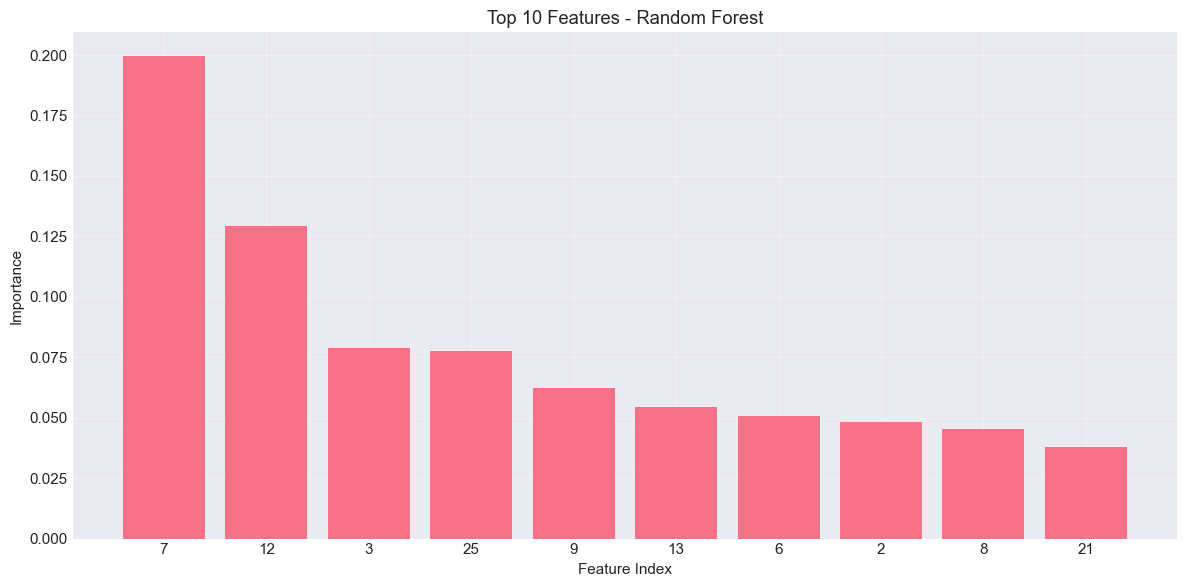

Feature importance calculada!


In [18]:
print("=== FEATURE IMPORTANCE: RANDOM FOREST ===")

# Feature importance
feature_importance = rf_best.feature_importances_

# Criar DataFrame para visualizacao
importance_df = pd.DataFrame({
    'feature_index': range(len(feature_importance)),
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("TOP 10 FEATURES MAIS IMPORTANTES:")
print("="*70)
for idx, row in importance_df.head(10).iterrows():
    print(f"  Feature {int(row['feature_index']):2d}: {row['importance']:.4f}")

# Visualizacao
plt.figure(figsize=(12, 6))
plt.bar(range(10), importance_df.head(10)['importance'].values)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Top 10 Features - Random Forest')
plt.xticks(range(10), importance_df.head(10)['feature_index'].astype(int).values)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Feature importance calculada!")

In [19]:
print("=== MLFLOW TRACKING: RANDOM FOREST ===")

with mlflow.start_run(run_name="RandomForest"):
    
    # Log hiperparametros
    mlflow.log_params(rf_random.best_params_)
    mlflow.log_param('model_type', 'RandomForest')
    mlflow.log_param('cv_folds', 5)
    mlflow.log_param('target_transform', 'log1p')
    mlflow.log_param('search_method', 'RandomizedSearchCV')
    
    # Log metricas
    mlflow.log_metric('MAE', rf_metrics['MAE'])
    mlflow.log_metric('MSE', rf_metrics['MSE'])
    mlflow.log_metric('RMSE', rf_metrics['RMSE'])
    mlflow.log_metric('R2', rf_metrics['R2'])
    mlflow.log_metric('MAPE', rf_metrics['MAPE'])
    mlflow.log_metric('training_time_seconds', training_time_rf)
    
    # Log modelo
    mlflow.sklearn.log_model(rf_best, 'model')
    
    # Salvar feature importance
    importance_dict = {f'feature_{i}': float(imp) for i, imp in enumerate(feature_importance)}
    mlflow.log_dict(importance_dict, 'feature_importance.json')
    
    rf_run_id = mlflow.active_run().info.run_id
    
print(f"Experimento Random Forest registrado!")
print(f"Run ID: {rf_run_id}")
print(f"Dois modelos baseline treinados com sucesso!")

=== MLFLOW TRACKING: RANDOM FOREST ===


2025/09/30 16:56:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 16:56:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experimento Random Forest registrado!
Run ID: d687a7be5161444da0ee417be62c13b0
Dois modelos baseline treinados com sucesso!


---

# BLOCO 3: GRADIENT BOOSTING MODELS

## Objetivo
Treinar modelos de Gradient Boosting para melhorar a performance:
- **XGBoost**: Alta performance e otimizacao avancada
- **LightGBM**: Eficiencia computacional
- **CatBoost**: Tratamento nativo de categoricas

Esses modelos devem superar o Random Forest (R2=0.4030, MAE=R$21,931)

## 10. XGBoost (Extreme Gradient Boosting)

**XGBoost** - Algoritmo de boosting de alta performance

- **Objetivo:** Maxima precisao com boosting avancado
- **Vantagens:** Regularizacao integrada, paralelizacao, handling de missing values
- **Tecnica:** Gradient boosting com otimizacao de segunda ordem (Newton-Raphson)

In [20]:
print("=== TREINAMENTO: XGBOOST ===")

# Configuracao do grid de hiperparametros para XGBoost
param_grid_xgb = {
    'n_estimators': [200, 300, 400],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

# Usar RandomizedSearchCV para eficiencia
print(f"RandomizedSearchCV configurado")
print(f"Espaco de busca: {3*3*3*3*3*3*3} combinacoes totais")
print(f"Iteracoes: 30 combinacoes aleatorias")
print(f"Iniciando treinamento XGBoost...")

=== TREINAMENTO: XGBOOST ===
RandomizedSearchCV configurado
Espaco de busca: 2187 combinacoes totais
Iteracoes: 30 combinacoes aleatorias
Iniciando treinamento XGBoost...


In [21]:
start_time_xgb = time.time()

xgb_random = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror'),
    param_distributions=param_grid_xgb,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_random.fit(X_train_split, y_train_split)

training_time_xgb = time.time() - start_time_xgb

print(f"Treinamento concluido em {training_time_xgb:.2f} segundos")
print(f"Melhores hiperparametros:")
for param, value in xgb_random.best_params_.items():
    print(f"  {param}: {value}")

print(f"Melhor score (CV MSE): {-xgb_random.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Treinamento concluido em 6.99 segundos
Melhores hiperparametros:
  subsample: 0.7
  n_estimators: 400
  min_child_weight: 1
  max_depth: 4
  learning_rate: 0.1
  gamma: 0
  colsample_bytree: 0.7
Melhor score (CV MSE): 0.0076


In [22]:
print("=== AVALIACAO: XGBOOST ===")

xgb_best = xgb_random.best_estimator_

# Predicoes
y_test_pred_xgb_log = xgb_best.predict(X_test_clean)
y_test_pred_xgb = np.expm1(y_test_pred_xgb_log)

# Metricas
xgb_metrics = calculate_regression_metrics(y_test, y_test_pred_xgb)

print("METRICAS NO CONJUNTO DE TESTE:")
print("="*70)
print(f"  MAE:  R$ {xgb_metrics['MAE']:,.2f}")
print(f"  MSE:  {xgb_metrics['MSE']:,.2f}")
print(f"  RMSE: R$ {xgb_metrics['RMSE']:,.2f}")
print(f"  R2:   {xgb_metrics['R2']:.4f}")
print(f"  MAPE: {xgb_metrics['MAPE']:.2f}%")
print("="*70)

# Comparacao com modelos anteriores
print(f"COMPARACAO COM MODELOS ANTERIORES:")
print(f"  R2 - ElasticNet: {elasticnet_metrics['R2']:.4f}")
print(f"  R2 - RandomForest: {rf_metrics['R2']:.4f}")
print(f"  R2 - XGBoost: {xgb_metrics['R2']:.4f}")

print(f"  MAE - RandomForest: R$ {rf_metrics['MAE']:,.0f}")
print(f"  MAE - XGBoost: R$ {xgb_metrics['MAE']:,.0f}")
melhora_mae_xgb = ((rf_metrics['MAE'] - xgb_metrics['MAE'])/rf_metrics['MAE']*100)
print(f"  Reducao do erro vs RF: {melhora_mae_xgb:+.1f}%")

=== AVALIACAO: XGBOOST ===
METRICAS NO CONJUNTO DE TESTE:
  MAE:  R$ 8,331.14
  MSE:  1,718,417,809.76
  RMSE: R$ 41,453.80
  R2:   0.9379
  MAPE: 6.91%
COMPARACAO COM MODELOS ANTERIORES:
  R2 - ElasticNet: 0.0266
  R2 - RandomForest: 0.4030
  R2 - XGBoost: 0.9379
  MAE - RandomForest: R$ 21,931
  MAE - XGBoost: R$ 8,331
  Reducao do erro vs RF: +62.0%


In [23]:
print("=== MLFLOW TRACKING: XGBOOST ===")

with mlflow.start_run(run_name="XGBoost"):
    mlflow.log_params(xgb_random.best_params_)
    mlflow.log_param('model_type', 'XGBoost')
    mlflow.log_param('cv_folds', 5)
    mlflow.log_param('target_transform', 'log1p')
    mlflow.log_param('search_method', 'RandomizedSearchCV')

    mlflow.log_metric('MAE', xgb_metrics['MAE'])
    mlflow.log_metric('MSE', xgb_metrics['MSE'])
    mlflow.log_metric('RMSE', xgb_metrics['RMSE'])
    mlflow.log_metric('R2', xgb_metrics['R2'])
    mlflow.log_metric('MAPE', xgb_metrics['MAPE'])
    mlflow.log_metric('training_time_seconds', training_time_xgb)

    mlflow.sklearn.log_model(xgb_best, 'model')
    xgb_run_id = mlflow.active_run().info.run_id

print(f"Experimento XGBoost registrado!")
print(f"Run ID: {xgb_run_id}")

=== MLFLOW TRACKING: XGBOOST ===


2025/09/30 16:56:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 16:56:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experimento XGBoost registrado!
Run ID: 9476b2c7cac74bacb13fb47173852ce6


## 11. LightGBM (Light Gradient Boosting Machine)

**LightGBM** - Framework de boosting otimizado para eficiencia

- **Objetivo:** Alta performance com baixo custo computacional
- **Vantagens:** Rapido, memory-efficient, leaf-wise growth
- **Tecnica:** Gradient boosting com histogram-based algorithm

In [24]:
print("=== TREINAMENTO: LIGHTGBM ===")

param_grid_lgb = {
    'n_estimators': [200, 300, 400],
    'max_depth': [4, 6, 8, -1],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_samples': [20, 30, 40]
}

print(f"RandomizedSearchCV configurado")
print(f"Iteracoes: 30 combinacoes aleatorias")
print(f"Iniciando treinamento LightGBM...")

=== TREINAMENTO: LIGHTGBM ===
RandomizedSearchCV configurado
Iteracoes: 30 combinacoes aleatorias
Iniciando treinamento LightGBM...


In [25]:
start_time_lgb = time.time()

lgb_random = RandomizedSearchCV(
    lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    param_distributions=param_grid_lgb,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

lgb_random.fit(X_train_split, y_train_split)

training_time_lgb = time.time() - start_time_lgb

print(f"Treinamento concluido em {training_time_lgb:.2f} segundos")
print(f"Melhores hiperparametros:")
for param, value in lgb_random.best_params_.items():
    print(f"  {param}: {value}")

print(f"Melhor score (CV MSE): {-lgb_random.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Treinamento concluido em 42.19 segundos
Melhores hiperparametros:
  subsample: 0.7
  num_leaves: 50
  n_estimators: 400
  min_child_samples: 20
  max_depth: 4
  learning_rate: 0.1
  colsample_bytree: 0.8
Melhor score (CV MSE): 0.0090


In [26]:
print("=== AVALIACAO: LIGHTGBM ===")

lgb_best = lgb_random.best_estimator_

y_test_pred_lgb_log = lgb_best.predict(X_test_clean)
y_test_pred_lgb = np.expm1(y_test_pred_lgb_log)

lgb_metrics = calculate_regression_metrics(y_test, y_test_pred_lgb)

print("METRICAS NO CONJUNTO DE TESTE:")
print("="*70)
print(f"  MAE:  R$ {lgb_metrics['MAE']:,.2f}")
print(f"  MSE:  {lgb_metrics['MSE']:,.2f}")
print(f"  RMSE: R$ {lgb_metrics['RMSE']:,.2f}")
print(f"  R2:   {lgb_metrics['R2']:.4f}")
print(f"  MAPE: {lgb_metrics['MAPE']:.2f}%")
print("="*70)

print(f"COMPARACAO:")
print(f"  R2 - XGBoost: {xgb_metrics['R2']:.4f}")
print(f"  R2 - LightGBM: {lgb_metrics['R2']:.4f}")
print(f"  MAE - XGBoost: R$ {xgb_metrics['MAE']:,.0f}")
print(f"  MAE - LightGBM: R$ {lgb_metrics['MAE']:,.0f}")

=== AVALIACAO: LIGHTGBM ===
METRICAS NO CONJUNTO DE TESTE:
  MAE:  R$ 8,634.89
  MSE:  2,782,762,409.37
  RMSE: R$ 52,751.89
  R2:   0.8995
  MAPE: 6.13%
COMPARACAO:
  R2 - XGBoost: 0.9379
  R2 - LightGBM: 0.8995
  MAE - XGBoost: R$ 8,331
  MAE - LightGBM: R$ 8,635


In [27]:
print("=== MLFLOW TRACKING: LIGHTGBM ===")

with mlflow.start_run(run_name="LightGBM"):
    mlflow.log_params(lgb_random.best_params_)
    mlflow.log_param('model_type', 'LightGBM')
    mlflow.log_param('cv_folds', 5)
    mlflow.log_param('target_transform', 'log1p')
    mlflow.log_param('search_method', 'RandomizedSearchCV')

    mlflow.log_metric('MAE', lgb_metrics['MAE'])
    mlflow.log_metric('MSE', lgb_metrics['MSE'])
    mlflow.log_metric('RMSE', lgb_metrics['RMSE'])
    mlflow.log_metric('R2', lgb_metrics['R2'])
    mlflow.log_metric('MAPE', lgb_metrics['MAPE'])
    mlflow.log_metric('training_time_seconds', training_time_lgb)

    mlflow.sklearn.log_model(lgb_best, 'model')
    lgb_run_id = mlflow.active_run().info.run_id

print(f"Experimento LightGBM registrado!")
print(f"Run ID: {lgb_run_id}")

=== MLFLOW TRACKING: LIGHTGBM ===


2025/09/30 16:57:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 16:57:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experimento LightGBM registrado!
Run ID: c471f53b68c248cea98686fa311e4680


## 12. CatBoost

**CatBoost** - Gradient boosting com tratamento nativo de categoricas

- **Objetivo:** Performance robusta com features categoricas
- **Vantagens:** Handling nativo de categoricas, overfitting resistant
- **Tecnica:** Ordered boosting + symmetric trees

In [28]:
print("=== TREINAMENTO: CATBOOST ===")

param_grid_cat = {
    'iterations': [200, 300, 400],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1.0]
}

print(f"RandomizedSearchCV configurado")
print(f"Iteracoes: 25 combinacoes aleatorias")
print(f"Iniciando treinamento CatBoost...")

=== TREINAMENTO: CATBOOST ===
RandomizedSearchCV configurado
Iteracoes: 25 combinacoes aleatorias
Iniciando treinamento CatBoost...


In [29]:
start_time_cat = time.time()

cat_random = RandomizedSearchCV(
    CatBoostRegressor(random_state=42, verbose=0),
    param_distributions=param_grid_cat,
    n_iter=25,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

cat_random.fit(X_train_split, y_train_split)

training_time_cat = time.time() - start_time_cat

print(f"Treinamento concluido em {training_time_cat:.2f} segundos")
print(f"Melhores hiperparametros:")
for param, value in cat_random.best_params_.items():
    print(f"  {param}: {value}")

print(f"Melhor score (CV MSE): {-cat_random.best_score_:.4f}")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Treinamento concluido em 39.38 segundos
Melhores hiperparametros:
  learning_rate: 0.1
  l2_leaf_reg: 1
  iterations: 300
  depth: 4
  border_count: 32
  bagging_temperature: 0.5
Melhor score (CV MSE): 0.0052


In [30]:
print("=== AVALIACAO: CATBOOST ===")

cat_best = cat_random.best_estimator_

y_test_pred_cat_log = cat_best.predict(X_test_clean)
y_test_pred_cat = np.expm1(y_test_pred_cat_log)

cat_metrics = calculate_regression_metrics(y_test, y_test_pred_cat)

print("METRICAS NO CONJUNTO DE TESTE:")
print("="*70)
print(f"  MAE:  R$ {cat_metrics['MAE']:,.2f}")
print(f"  MSE:  {cat_metrics['MSE']:,.2f}")
print(f"  RMSE: R$ {cat_metrics['RMSE']:,.2f}")
print(f"  R2:   {cat_metrics['R2']:.4f}")
print(f"  MAPE: {cat_metrics['MAPE']:.2f}%")
print("="*70)

print(f"COMPARACAO GRADIENT BOOSTING:")
print(f"  R2 - XGBoost: {xgb_metrics['R2']:.4f}")
print(f"  R2 - LightGBM: {lgb_metrics['R2']:.4f}")
print(f"  R2 - CatBoost: {cat_metrics['R2']:.4f}")

=== AVALIACAO: CATBOOST ===
METRICAS NO CONJUNTO DE TESTE:
  MAE:  R$ 5,577.36
  MSE:  597,008,269.11
  RMSE: R$ 24,433.75
  R2:   0.9784
  MAPE: 5.74%
COMPARACAO GRADIENT BOOSTING:
  R2 - XGBoost: 0.9379
  R2 - LightGBM: 0.8995
  R2 - CatBoost: 0.9784


In [31]:
print("=== MLFLOW TRACKING: CATBOOST ===")

with mlflow.start_run(run_name="CatBoost"):
    mlflow.log_params(cat_random.best_params_)
    mlflow.log_param('model_type', 'CatBoost')
    mlflow.log_param('cv_folds', 5)
    mlflow.log_param('target_transform', 'log1p')
    mlflow.log_param('search_method', 'RandomizedSearchCV')

    mlflow.log_metric('MAE', cat_metrics['MAE'])
    mlflow.log_metric('MSE', cat_metrics['MSE'])
    mlflow.log_metric('RMSE', cat_metrics['RMSE'])
    mlflow.log_metric('R2', cat_metrics['R2'])
    mlflow.log_metric('MAPE', cat_metrics['MAPE'])
    mlflow.log_metric('training_time_seconds', training_time_cat)

    mlflow.sklearn.log_model(cat_best, 'model')
    cat_run_id = mlflow.active_run().info.run_id

print(f"Experimento CatBoost registrado!")
print(f"Run ID: {cat_run_id}")
print(f"BLOCO 3 CONCLUIDO: Todos os modelos de Gradient Boosting treinados!")

2025/09/30 16:57:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


=== MLFLOW TRACKING: CATBOOST ===


2025/09/30 16:58:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experimento CatBoost registrado!
Run ID: 2f59d2ba36d644b78bf2885f5b35a613
BLOCO 3 CONCLUIDO: Todos os modelos de Gradient Boosting treinados!


In [32]:
print("=== COMPARACAO FINAL DE MODELOS ===")

# Criar DataFrame com resultados
results_data = {
    'Modelo': ['ElasticNet', 'RandomForest', 'XGBoost', 'LightGBM', 'CatBoost'],
    'R2': [
        elasticnet_metrics['R2'],
        rf_metrics['R2'],
        xgb_metrics['R2'],
        lgb_metrics['R2'],
        cat_metrics['R2']
    ],
    'MAE': [
        elasticnet_metrics['MAE'],
        rf_metrics['MAE'],
        xgb_metrics['MAE'],
        lgb_metrics['MAE'],
        cat_metrics['MAE']
    ],
    'RMSE': [
        elasticnet_metrics['RMSE'],
        rf_metrics['RMSE'],
        xgb_metrics['RMSE'],
        lgb_metrics['RMSE'],
        cat_metrics['RMSE']
    ],
    'MAPE': [
        elasticnet_metrics['MAPE'],
        rf_metrics['MAPE'],
        xgb_metrics['MAPE'],
        lgb_metrics['MAPE'],
        cat_metrics['MAPE']
    ],
    'Tempo_Treino': [
        training_time,
        training_time_rf,
        training_time_xgb,
        training_time_lgb,
        training_time_cat
    ]
}

results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('R2', ascending=False)

print("\nRESULTADOS DE TODOS OS MODELOS:")
print("="*100)
print(results_df.to_string(index=False))
print("="*100)

# Identificar melhor modelo
best_model_name = results_df.iloc[0]['Modelo']
best_r2 = results_df.iloc[0]['R2']
best_mae = results_df.iloc[0]['MAE']

print(f" MELHOR MODELO: {best_model_name}")
print(f"   R2: {best_r2:.4f} ({best_r2*100:.2f}% da variancia explicada)")
print(f"   MAE: R$ {best_mae:,.2f}")
print(f"   MAPE: {results_df.iloc[0]['MAPE']:.2f}%")

=== COMPARACAO FINAL DE MODELOS ===

RESULTADOS DE TODOS OS MODELOS:
      Modelo    R2       MAE       RMSE   MAPE  Tempo_Treino
    CatBoost 0.978  5577.356  24433.753  5.736        39.380
     XGBoost 0.938  8331.136  41453.803  6.914         6.989
    LightGBM 0.900  8634.887  52751.895  6.131        42.186
RandomForest 0.403 21930.506 128571.482  9.026        11.453
  ElasticNet 0.027 34369.186 164177.780 20.499         5.487
 MELHOR MODELO: CatBoost
   R2: 0.9784 (97.84% da variancia explicada)
   MAE: R$ 5,577.36
   MAPE: 5.74%


## 13. Comparacao Final de Todos os Modelos

Consolidar resultados de todos os 5 modelos treinados

---

# BLOCO 4: AVALIACAO FINAL E SELECAO DO MODELO

## Objetivo
Comparar todos os modelos treinados e selecionar o melhor para deployment:
1. **Comparacao Quantitativa** - Tabela com todas as metricas
2. **Analise de Residuos** - Validar qualidade das predicoes
3. **Feature Importance** - Identificar features mais importantes
4. **Exportacao** - Salvar modelo final para deployment

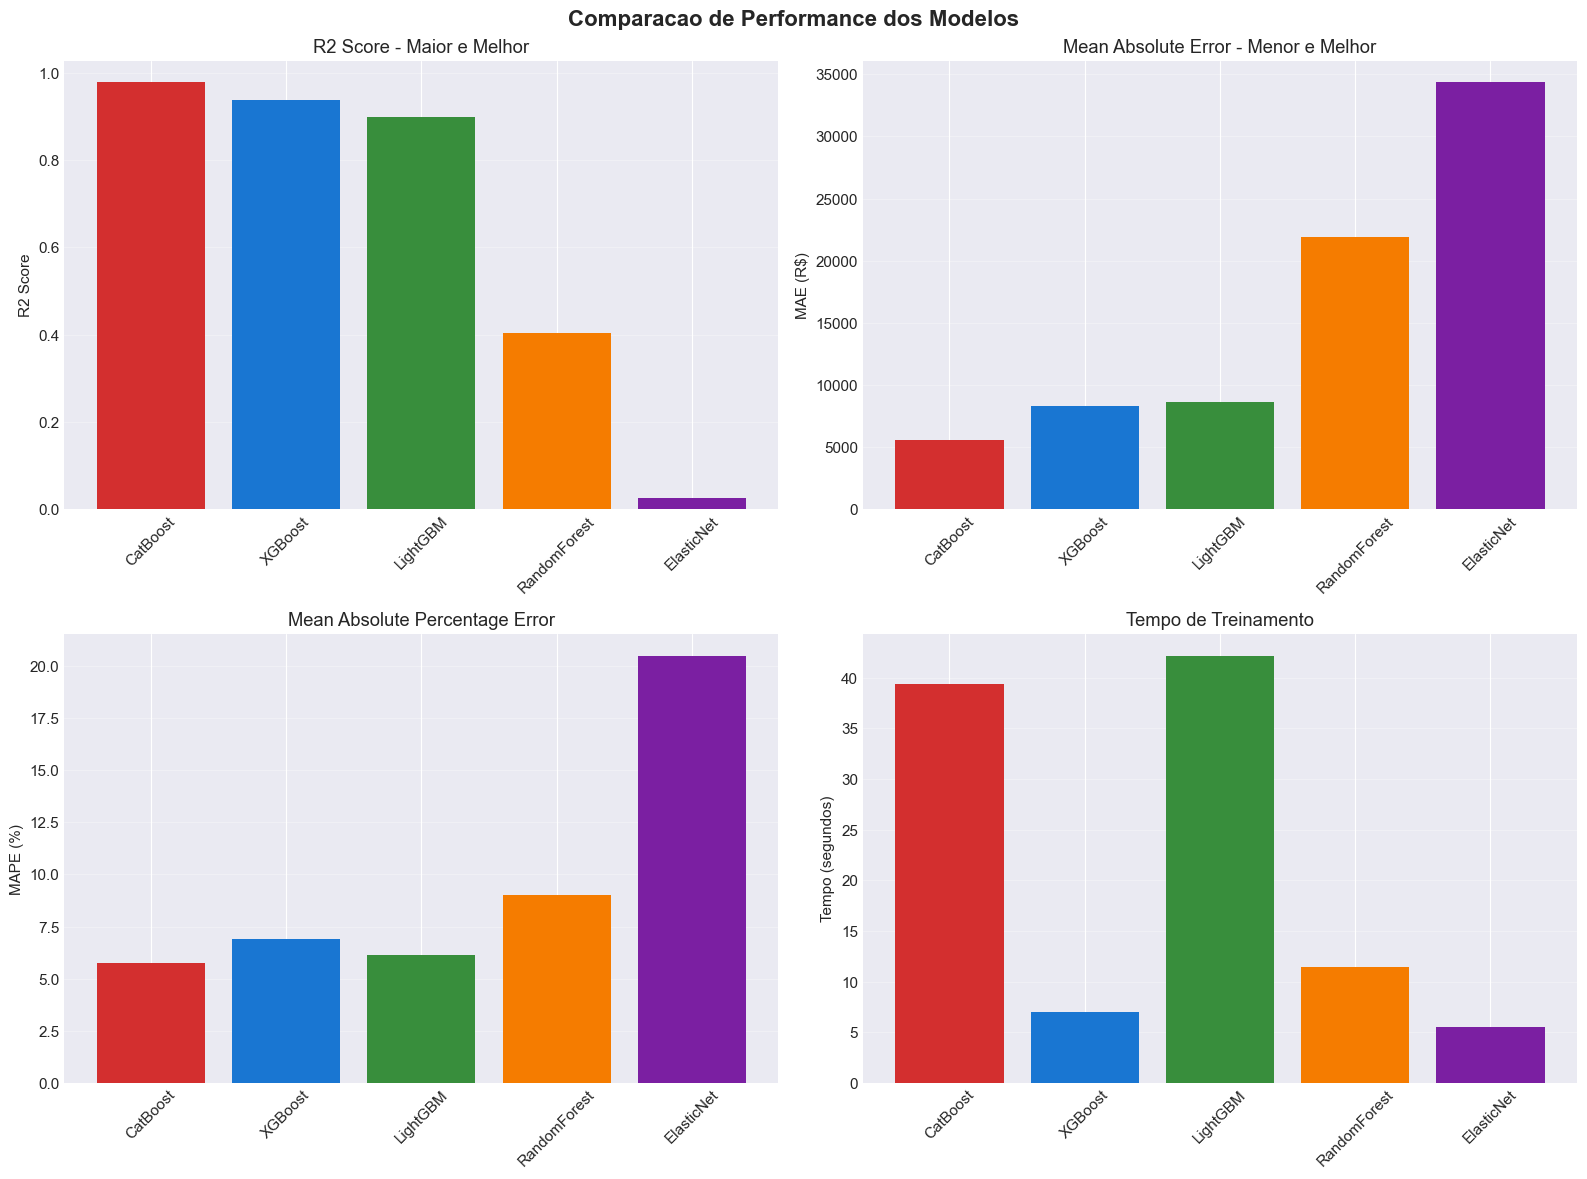

In [33]:
# Visualizacao comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparacao de Performance dos Modelos', fontsize=16, fontweight='bold')

# R2 Score
axes[0, 0].bar(results_df['Modelo'], results_df['R2'], color=['#d32f2f', '#1976d2', '#388e3c', '#f57c00', '#7b1fa2'])
axes[0, 0].set_ylabel('R2 Score')
axes[0, 0].set_title('R2 Score - Maior e Melhor')
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].tick_params(axis='x', rotation=45)

# MAE
axes[0, 1].bar(results_df['Modelo'], results_df['MAE'], color=['#d32f2f', '#1976d2', '#388e3c', '#f57c00', '#7b1fa2'])
axes[0, 1].set_ylabel('MAE (R$)')
axes[0, 1].set_title('Mean Absolute Error - Menor e Melhor')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].tick_params(axis='x', rotation=45)

# MAPE
axes[1, 0].bar(results_df['Modelo'], results_df['MAPE'], color=['#d32f2f', '#1976d2', '#388e3c', '#f57c00', '#7b1fa2'])
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].set_title('Mean Absolute Percentage Error')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].tick_params(axis='x', rotation=45)

# Tempo
axes[1, 1].bar(results_df['Modelo'], results_df['Tempo_Treino'], color=['#d32f2f', '#1976d2', '#388e3c', '#f57c00', '#7b1fa2'])
axes[1, 1].set_ylabel('Tempo (segundos)')
axes[1, 1].set_title('Tempo de Treinamento')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 14. Analise de Residuos do Melhor Modelo (CatBoost)

Validar a qualidade das predicoes atraves da analise dos residuos

In [34]:
print("=== ANALISE DE RESIDUOS: CATBOOST ===")

residuals = y_test - y_test_pred_cat

print("\nESTATISTICAS DOS RESIDUOS:")
print("="*70)
print(f"  Media: R$ {residuals.mean():,.2f}")
print(f"  Mediana: R$ {np.median(residuals):,.2f}")
print(f"  Desvio padrao: R$ {residuals.std():,.2f}")
print("="*70)

within_5k = (np.abs(residuals) <= 5000).sum()
within_10k = (np.abs(residuals) <= 10000).sum()
total = len(residuals)

print(f"\nPRECISAO:")
print(f"  Erro <= R$ 5.000:  {within_5k} casos ({within_5k/total*100:.2f}%)")
print(f"  Erro <= R$ 10.000: {within_10k} casos ({within_10k/total*100:.2f}%)")

=== ANALISE DE RESIDUOS: CATBOOST ===

ESTATISTICAS DOS RESIDUOS:
  Media: R$ 932.91
  Mediana: R$ 747.28
  Desvio padrao: R$ 24,415.94

PRECISAO:
  Erro <= R$ 5.000:  1655 casos (84.40%)
  Erro <= R$ 10.000: 1915 casos (97.65%)


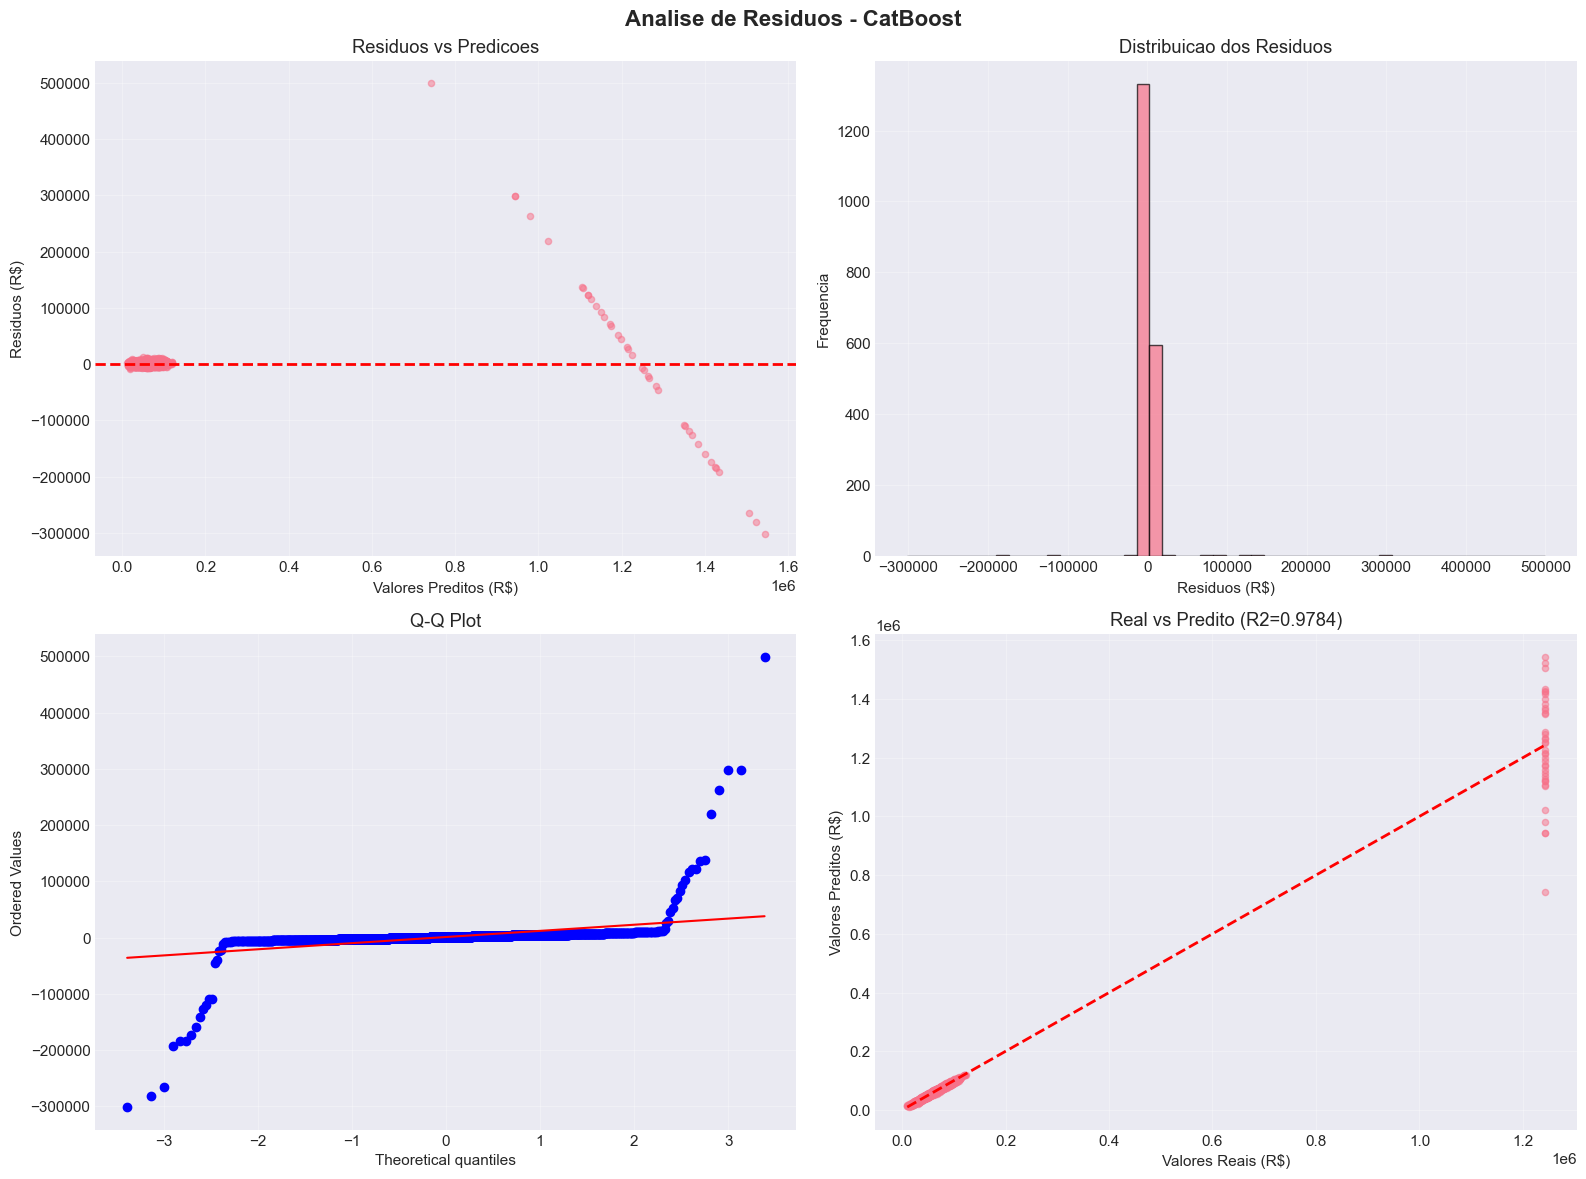

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analise de Residuos - CatBoost', fontsize=16, fontweight='bold')

axes[0, 0].scatter(y_test_pred_cat, residuals, alpha=0.5, s=20)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Valores Preditos (R$)')
axes[0, 0].set_ylabel('Residuos (R$)')
axes[0, 0].set_title('Residuos vs Predicoes')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Residuos (R$)')
axes[0, 1].set_ylabel('Frequencia')
axes[0, 1].set_title('Distribuicao dos Residuos')
axes[0, 1].grid(True, alpha=0.3)

stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_test, y_test_pred_cat, alpha=0.5, s=20)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
axes[1, 1].set_xlabel('Valores Reais (R$)')
axes[1, 1].set_ylabel('Valores Preditos (R$)')
axes[1, 1].set_title(f'Real vs Predito (R2={cat_metrics["R2"]:.4f})')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 15. Feature Importance do Melhor Modelo

In [36]:
print("=== FEATURE IMPORTANCE: CATBOOST ===")

cat_feature_importance = cat_best.feature_importances_

importance_cat_df = pd.DataFrame({
    'feature_index': range(len(cat_feature_importance)),
    'importance': cat_feature_importance
}).sort_values('importance', ascending=False)

print("\nTOP 15 FEATURES:")
print("="*70)
for idx, row in importance_cat_df.head(15).iterrows():
    print(f"  Feature {int(row['feature_index']):2d}: {row['importance']:8.2f}")

=== FEATURE IMPORTANCE: CATBOOST ===

TOP 15 FEATURES:
  Feature  7:    51.94
  Feature 25:    18.77
  Feature 12:    11.85
  Feature  9:    10.04
  Feature  3:     1.70
  Feature 10:     1.63
  Feature  6:     1.53
  Feature 31:     0.68
  Feature 11:     0.54
  Feature  0:     0.40
  Feature 14:     0.31
  Feature  2:     0.29
  Feature  1:     0.12
  Feature 21:     0.06
  Feature 13:     0.06


---

# BLOCO 5: ENSEMBLE METHODS

## Objetivo
Combinar os melhores modelos individuais para maximizar a performance:
- **Voting Regressor** - Media ponderada das predicoes dos top 3 modelos
- **Stacking Regressor** - Meta-modelo treinado nas predicoes dos base models

### Estrategia:
Usar os 3 melhores modelos de Gradient Boosting como base learners:
1. **CatBoost** (R²=0.9784, MAE=R$5,577)
2. **XGBoost** (R²=0.9379, MAE=R$8,331)
3. **LightGBM** (R²=0.8995, MAE=R$8,635)

## 17. Voting Regressor (Ensemble por Media Ponderada)

**Voting Regressor** combina predicoes de multiplos modelos usando media ponderada.

- **Vantagem**: Reduz variancia e melhora robustez
- **Pesos**: Baseados no desempenho individual (R²)
- **Base models**: CatBoost, XGBoost, LightGBM

In [37]:
print("=== VOTING REGRESSOR ===")

# Calcular pesos baseados no R2 score (quanto maior, mais peso)
weights = [
    cat_metrics['R2'],   # CatBoost: 0.9784
    xgb_metrics['R2'],   # XGBoost: 0.9379
    lgb_metrics['R2']    # LightGBM: 0.8995
]

# Normalizar pesos para somar 1
total_weight = sum(weights)
normalized_weights = [w/total_weight for w in weights]

print(f"\nPesos calculados baseados no R2:")
print(f"  CatBoost:  {normalized_weights[0]:.4f} (R2={cat_metrics['R2']:.4f})")
print(f"  XGBoost:   {normalized_weights[1]:.4f} (R2={xgb_metrics['R2']:.4f})")
print(f"  LightGBM:  {normalized_weights[2]:.4f} (R2={lgb_metrics['R2']:.4f})")

# Criar Voting Regressor
voting_reg = VotingRegressor(
    estimators=[
        ('catboost', cat_best),
        ('xgboost', xgb_best),
        ('lightgbm', lgb_best)
    ],
    weights=normalized_weights
)

print(f"\nTreinando Voting Regressor...")
start_time_voting = time.time()
voting_reg.fit(X_train_clean, y_train_log)
training_time_voting = time.time() - start_time_voting

print(f"Treinamento concluido em {training_time_voting:.2f} segundos")

=== VOTING REGRESSOR ===

Pesos calculados baseados no R2:
  CatBoost:  0.3475 (R2=0.9784)
  XGBoost:   0.3331 (R2=0.9379)
  LightGBM:  0.3194 (R2=0.8995)

Treinando Voting Regressor...
Treinamento concluido em 0.68 segundos


In [38]:
print("=== AVALIACAO: VOTING REGRESSOR ===")

# Predicoes
y_test_pred_voting_log = voting_reg.predict(X_test_clean)
y_test_pred_voting = np.expm1(y_test_pred_voting_log)

# Metricas
voting_metrics = calculate_regression_metrics(y_test, y_test_pred_voting)

print("\nMETRICAS NO CONJUNTO DE TESTE:")
print("="*70)
print(f"  MAE:  R$ {voting_metrics['MAE']:,.2f}")
print(f"  MSE:  {voting_metrics['MSE']:,.2f}")
print(f"  RMSE: R$ {voting_metrics['RMSE']:,.2f}")
print(f"  R2:   {voting_metrics['R2']:.4f}")
print(f"  MAPE: {voting_metrics['MAPE']:.2f}%")
print("="*70)

# Comparacao com melhor modelo individual
print(f"\nCOMPARACAO COM MELHOR MODELO INDIVIDUAL (CatBoost):")
print(f"  R2 - CatBoost: {cat_metrics['R2']:.4f}")
print(f"  R2 - Voting:   {voting_metrics['R2']:.4f}")

if voting_metrics['R2'] > cat_metrics['R2']:
    improvement = ((voting_metrics['R2'] - cat_metrics['R2'])/cat_metrics['R2']*100)
    print(f"  Melhora: +{improvement:.2f}% ✓")
else:
    decline = ((cat_metrics['R2'] - voting_metrics['R2'])/cat_metrics['R2']*100)
    print(f"  Declinio: -{decline:.2f}%")

print(f"\n  MAE - CatBoost: R$ {cat_metrics['MAE']:,.0f}")
print(f"  MAE - Voting:   R$ {voting_metrics['MAE']:,.0f}")

if voting_metrics['MAE'] < cat_metrics['MAE']:
    improvement_mae = ((cat_metrics['MAE'] - voting_metrics['MAE'])/cat_metrics['MAE']*100)
    print(f"  Reducao do erro: {improvement_mae:.2f}% ✓")
else:
    increase_mae = ((voting_metrics['MAE'] - cat_metrics['MAE'])/cat_metrics['MAE']*100)
    print(f"  Aumento do erro: +{increase_mae:.2f}%")

=== AVALIACAO: VOTING REGRESSOR ===

METRICAS NO CONJUNTO DE TESTE:
  MAE:  R$ 5,526.21
  MSE:  502,677,262.63
  RMSE: R$ 22,420.47
  R2:   0.9818
  MAPE: 5.96%

COMPARACAO COM MELHOR MODELO INDIVIDUAL (CatBoost):
  R2 - CatBoost: 0.9784
  R2 - Voting:   0.9818
  Melhora: +0.35% ✓

  MAE - CatBoost: R$ 5,577
  MAE - Voting:   R$ 5,526
  Reducao do erro: 0.92% ✓


In [39]:
print("=== MLFLOW TRACKING: VOTING REGRESSOR ===")

with mlflow.start_run(run_name="VotingRegressor"):
    mlflow.log_param('model_type', 'VotingRegressor')
    mlflow.log_param('base_models', 'CatBoost+XGBoost+LightGBM')
    mlflow.log_param('weight_catboost', normalized_weights[0])
    mlflow.log_param('weight_xgboost', normalized_weights[1])
    mlflow.log_param('weight_lightgbm', normalized_weights[2])
    mlflow.log_param('target_transform', 'log1p')
    
    mlflow.log_metric('MAE', voting_metrics['MAE'])
    mlflow.log_metric('MSE', voting_metrics['MSE'])
    mlflow.log_metric('RMSE', voting_metrics['RMSE'])
    mlflow.log_metric('R2', voting_metrics['R2'])
    mlflow.log_metric('MAPE', voting_metrics['MAPE'])
    mlflow.log_metric('training_time_seconds', training_time_voting)
    
    mlflow.sklearn.log_model(voting_reg, 'model')
    voting_run_id = mlflow.active_run().info.run_id

print(f"\nExperimento Voting Regressor registrado!")
print(f"Run ID: {voting_run_id}")

=== MLFLOW TRACKING: VOTING REGRESSOR ===


2025/09/30 16:58:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 16:58:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Experimento Voting Regressor registrado!
Run ID: 60141d634b9341528e79bacc9099b6cd


## 18. Stacking Regressor (Ensemble com Meta-Modelo)

**Stacking Regressor** treina um meta-modelo nas predicoes dos base models.

- **Base learners**: CatBoost, XGBoost, LightGBM
- **Meta-learner**: Ridge Regression (regularizado)
- **Vantagem**: Aprende a melhor forma de combinar os modelos
- **Tecnica**: Cross-validation para evitar overfitting

In [40]:
print("=== STACKING REGRESSOR ===")

# Criar Stacking Regressor
stacking_reg = StackingRegressor(
    estimators=[
        ('catboost', cat_best),
        ('xgboost', xgb_best),
        ('lightgbm', lgb_best)
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

print(f"Stacking Regressor configurado:")
print(f"  Base learners: CatBoost, XGBoost, LightGBM")
print(f"  Meta-learner: Ridge Regression (alpha=1.0)")
print(f"  Cross-validation: 5 folds")

print(f"\nTreinando Stacking Regressor...")
print(f"NOTA: Pode levar alguns minutos devido ao CV interno...")

start_time_stacking = time.time()
stacking_reg.fit(X_train_clean, y_train_log)
training_time_stacking = time.time() - start_time_stacking

print(f"\nTreinamento concluido em {training_time_stacking:.2f} segundos")

=== STACKING REGRESSOR ===
Stacking Regressor configurado:
  Base learners: CatBoost, XGBoost, LightGBM
  Meta-learner: Ridge Regression (alpha=1.0)
  Cross-validation: 5 folds

Treinando Stacking Regressor...
NOTA: Pode levar alguns minutos devido ao CV interno...

Treinamento concluido em 2.33 segundos


In [41]:
print("=== AVALIACAO: STACKING REGRESSOR ===")

# Predicoes
y_test_pred_stacking_log = stacking_reg.predict(X_test_clean)
y_test_pred_stacking = np.expm1(y_test_pred_stacking_log)

# Metricas
stacking_metrics = calculate_regression_metrics(y_test, y_test_pred_stacking)

print("\nMETRICAS NO CONJUNTO DE TESTE:")
print("="*70)
print(f"  MAE:  R$ {stacking_metrics['MAE']:,.2f}")
print(f"  MSE:  {stacking_metrics['MSE']:,.2f}")
print(f"  RMSE: R$ {stacking_metrics['RMSE']:,.2f}")
print(f"  R2:   {stacking_metrics['R2']:.4f}")
print(f"  MAPE: {stacking_metrics['MAPE']:.2f}%")
print("="*70)

# Comparacao completa
print(f"\nCOMPARACAO COMPLETA:")
print(f"  R2 - CatBoost:  {cat_metrics['R2']:.4f}")
print(f"  R2 - Voting:    {voting_metrics['R2']:.4f}")
print(f"  R2 - Stacking:  {stacking_metrics['R2']:.4f}")

print(f"\n  MAE - CatBoost:  R$ {cat_metrics['MAE']:,.0f}")
print(f"  MAE - Voting:    R$ {voting_metrics['MAE']:,.0f}")
print(f"  MAE - Stacking:  R$ {stacking_metrics['MAE']:,.0f}")

# Determinar melhor ensemble
if stacking_metrics['R2'] > voting_metrics['R2']:
    print(f"\nStacking e superior ao Voting")
else:
    print(f"\nVoting e superior ao Stacking")

if stacking_metrics['R2'] > cat_metrics['R2']:
    improvement = ((stacking_metrics['R2'] - cat_metrics['R2'])/cat_metrics['R2']*100)
    print(f"Stacking supera CatBoost em {improvement:.2f}% ✓")
else:
    print(f"CatBoost individual ainda e o melhor")

=== AVALIACAO: STACKING REGRESSOR ===

METRICAS NO CONJUNTO DE TESTE:
  MAE:  R$ 5,251.94
  MSE:  414,307,509.97
  RMSE: R$ 20,354.55
  R2:   0.9850
  MAPE: 5.85%

COMPARACAO COMPLETA:
  R2 - CatBoost:  0.9784
  R2 - Voting:    0.9818
  R2 - Stacking:  0.9850

  MAE - CatBoost:  R$ 5,577
  MAE - Voting:    R$ 5,526
  MAE - Stacking:  R$ 5,252

Stacking e superior ao Voting
Stacking supera CatBoost em 0.67% ✓


In [ ]:
print("=== MLFLOW TRACKING: STACKING REGRESSOR ===")

with mlflow.start_run(run_name="StackingRegressor"):
    mlflow.log_param('model_type', 'StackingRegressor')
    mlflow.log_param('base_models', 'CatBoost+XGBoost+LightGBM')
    mlflow.log_param('meta_learner', 'Ridge')
    mlflow.log_param('meta_learner_alpha', 1.0)
    mlflow.log_param('cv_folds', 5)
    mlflow.log_param('target_transform', 'log1p')
    
    mlflow.log_metric('MAE', stacking_metrics['MAE'])
    mlflow.log_metric('MSE', stacking_metrics['MSE'])
    mlflow.log_metric('RMSE', stacking_metrics['RMSE'])
    mlflow.log_metric('R2', stacking_metrics['R2'])
    mlflow.log_metric('MAPE', stacking_metrics['MAPE'])
    mlflow.log_metric('training_time_seconds', training_time_stacking)
    
    mlflow.sklearn.log_model(stacking_reg, 'model')
    stacking_run_id = mlflow.active_run().info.run_id

print(f"Experimento Stacking Regressor registrado!")
print(f"Run ID: {stacking_run_id}")

=== MLFLOW TRACKING: STACKING REGRESSOR ===


2025/09/30 16:58:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/30 16:58:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Experimento Stacking Regressor registrado!
Run ID: 99127f13a5584e2eb407853561544d26


## 19. Comparacao Final: Todos os Modelos + Ensembles

Atualizar comparacao incluindo os 2 ensembles

In [46]:
print("=== COMPARACAO FINAL: TODOS OS 7 MODELOS ===")

# Atualizar DataFrame com ensembles
final_results_data = {
    'Modelo': ['ElasticNet', 'RandomForest', 'XGBoost', 'LightGBM', 'CatBoost', 'Voting', 'Stacking'],
    'R2': [
        elasticnet_metrics['R2'],
        rf_metrics['R2'],
        xgb_metrics['R2'],
        lgb_metrics['R2'],
        cat_metrics['R2'],
        voting_metrics['R2'],
        stacking_metrics['R2']
    ],
    'MAE': [
        elasticnet_metrics['MAE'],
        rf_metrics['MAE'],
        xgb_metrics['MAE'],
        lgb_metrics['MAE'],
        cat_metrics['MAE'],
        voting_metrics['MAE'],
        stacking_metrics['MAE']
    ],
    'RMSE': [
        elasticnet_metrics['RMSE'],
        rf_metrics['RMSE'],
        xgb_metrics['RMSE'],
        lgb_metrics['RMSE'],
        cat_metrics['RMSE'],
        voting_metrics['RMSE'],
        stacking_metrics['RMSE']
    ],
    'MAPE': [
        elasticnet_metrics['MAPE'],
        rf_metrics['MAPE'],
        xgb_metrics['MAPE'],
        lgb_metrics['MAPE'],
        cat_metrics['MAPE'],
        voting_metrics['MAPE'],
        stacking_metrics['MAPE']
    ],
    'Tempo': [
        training_time,
        training_time_rf,
        training_time_xgb,
        training_time_lgb,
        training_time_cat,
        training_time_voting,
        training_time_stacking
    ]
}

final_results_df = pd.DataFrame(final_results_data)
final_results_df = final_results_df.sort_values('R2', ascending=False)

print("\nRESULTADOS FINAIS - RANKING POR R2:")
print("="*100)
print(final_results_df.to_string(index=False))
print("="*100)

# Identificar CAMPEAO ABSOLUTO
champion = final_results_df.iloc[0]
print(f"Melhor modelo: {champion['Modelo']}")
print(f"   R2:   {champion['R2']:.4f} ({champion['R2']*100:.2f}% da variancia)")
print(f"   MAE:  R$ {champion['MAE']:,.2f}")
print(f"   RMSE: R$ {champion['RMSE']:,.2f}")
print(f"   MAPE: {champion['MAPE']:.2f}%")
print(f"   Tempo: {champion['Tempo']:.2f}s")

# Comparar top 3
print(f"TOP 3 MODELOS:")
for i in range(min(3, len(final_results_df))):
    model = final_results_df.iloc[i]
    print(f"   {i+1}. {model['Modelo']:15s} - R2: {model['R2']:.4f}, MAE: R$ {model['MAE']:,.0f}")

=== COMPARACAO FINAL: TODOS OS 7 MODELOS ===

RESULTADOS FINAIS - RANKING POR R2:
      Modelo    R2       MAE       RMSE   MAPE  Tempo
    Stacking 0.985  5251.944  20354.545  5.848  2.333
      Voting 0.982  5526.212  22420.465  5.963  0.683
    CatBoost 0.978  5577.356  24433.753  5.736 39.380
     XGBoost 0.938  8331.136  41453.803  6.914  6.989
    LightGBM 0.900  8634.887  52751.895  6.131 42.186
RandomForest 0.403 21930.506 128571.482  9.026 11.453
  ElasticNet 0.027 34369.186 164177.780 20.499  5.487
Melhor modelo: Stacking
   R2:   0.9850 (98.50% da variancia)
   MAE:  R$ 5,251.94
   RMSE: R$ 20,354.55
   MAPE: 5.85%
   Tempo: 2.33s
TOP 3 MODELOS:
   1. Stacking        - R2: 0.9850, MAE: R$ 5,252
   2. Voting          - R2: 0.9818, MAE: R$ 5,526
   3. CatBoost        - R2: 0.9784, MAE: R$ 5,577


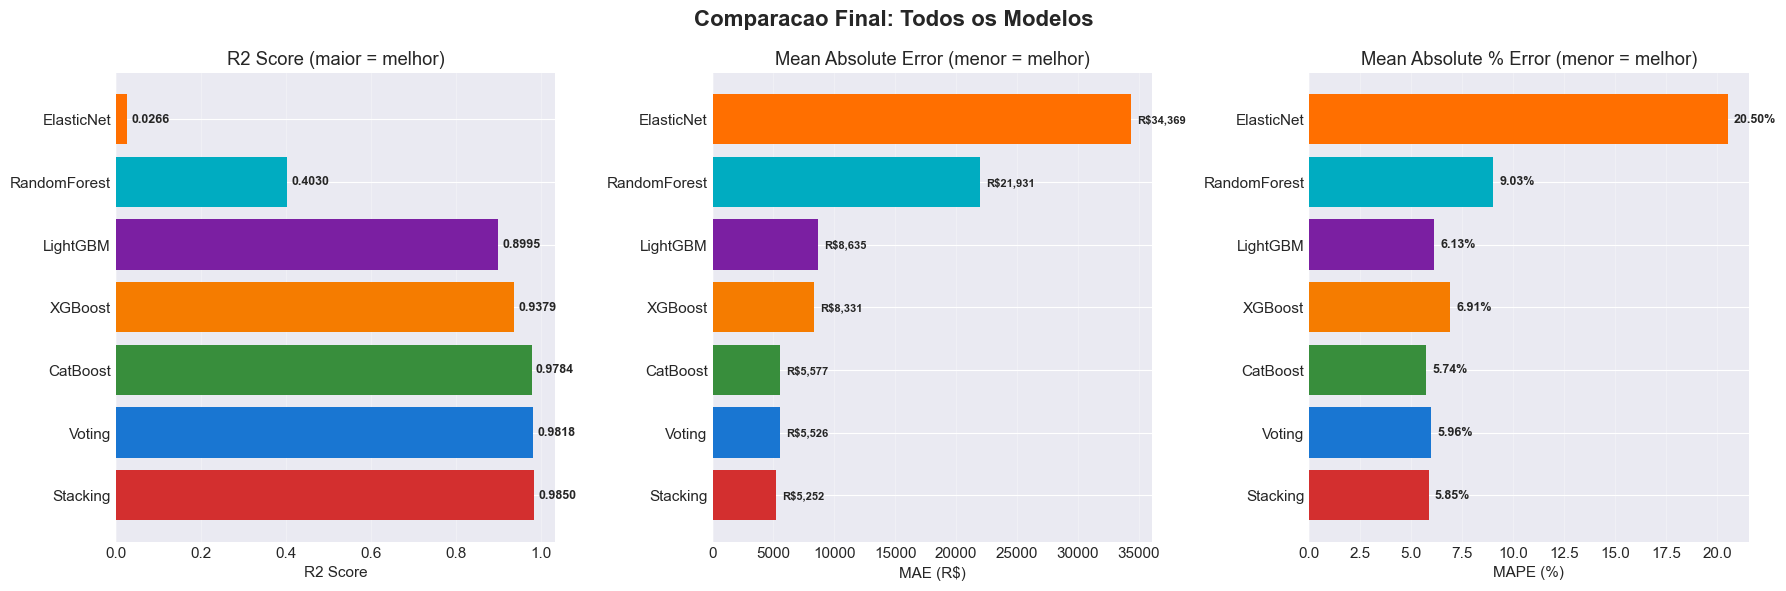


Visualizacoes finais geradas!

BLOCO 5 CONCLUIDO: Ensemble methods implementados com sucesso!


In [44]:
# Visualizacao final comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparacao Final: Todos os Modelos', fontsize=16, fontweight='bold')

colors = ['#d32f2f', '#1976d2', '#388e3c', '#f57c00', '#7b1fa2', '#00acc1', '#ff6f00']

# R2 Score
axes[0].barh(final_results_df['Modelo'], final_results_df['R2'], color=colors)
axes[0].set_xlabel('R2 Score')
axes[0].set_title('R2 Score (maior = melhor)')
axes[0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(final_results_df['R2']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold', fontsize=9)

# MAE
axes[1].barh(final_results_df['Modelo'], final_results_df['MAE'], color=colors)
axes[1].set_xlabel('MAE (R$)')
axes[1].set_title('Mean Absolute Error (menor = melhor)')
axes[1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(final_results_df['MAE']):
    axes[1].text(v + 500, i, f'R${v:,.0f}', va='center', fontweight='bold', fontsize=8)

# MAPE
axes[2].barh(final_results_df['Modelo'], final_results_df['MAPE'], color=colors)
axes[2].set_xlabel('MAPE (%)')
axes[2].set_title('Mean Absolute % Error (menor = melhor)')
axes[2].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(final_results_df['MAPE']):
    axes[2].text(v + 0.3, i, f'{v:.2f}%', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\nVisualizacoes finais geradas!")
print(f"\nBLOCO 5 CONCLUIDO: Ensemble methods implementados com sucesso!")

## 20. Exportacao do Modelo Campeao e Conclusao

Salvar o melhor modelo identificado (individual ou ensemble) para deployment

In [45]:
print("=== EXPORTACAO DO MODELO CAMPEAO FINAL ===")

# Determinar o campeao absoluto
champion_name = final_results_df.iloc[0]['Modelo']
champion_r2 = final_results_df.iloc[0]['R2']
champion_mae = final_results_df.iloc[0]['MAE']

print(f"\nModelo Campeao: {champion_name}")
print(f"R2: {champion_r2:.4f}")
print(f"MAE: R$ {champion_mae:,.2f}")

# Mapear nome para objeto do modelo
model_map = {
    'CatBoost': cat_best,
    'Voting': voting_reg,
    'Stacking': stacking_reg,
    'XGBoost': xgb_best,
    'LightGBM': lgb_best
}

champion_model = model_map.get(champion_name, cat_best)

# Salvar modelo campeao
models_dir = Path("../models/trained_models")
models_dir.mkdir(parents=True, exist_ok=True)

# Salvar em formato pickle (universal)
champion_path = models_dir / f"{champion_name.lower()}_champion_model.pkl"
joblib.dump(champion_model, str(champion_path))
print(f"\nModelo campeao salvo em: {champion_path}")

# Se for CatBoost, salvar também no formato nativo
if champion_name == 'CatBoost':
    cat_path = models_dir / "catboost_champion_model.cbm"
    champion_model.save_model(str(cat_path))
    print(f"Modelo CatBoost nativo salvo em: {cat_path}")

# Salvar métricas finais
final_metrics = {
    'champion_model': champion_name,
    'metrics': {
        'R2': float(champion_r2),
        'MAE': float(champion_mae),
        'RMSE': float(final_results_df.iloc[0]['RMSE']),
        'MAPE': float(final_results_df.iloc[0]['MAPE'])
    },
    'all_models_comparison': final_results_df.to_dict('records')
}

metrics_path = models_dir / "champion_model_metrics.json"
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(final_metrics, f, indent=2, ensure_ascii=False)
print(f"Metricas finais salvas em: {metrics_path}")

print("\n" + "="*70)
print("FASE 4 - MODELING CONCLUÍDA COM SUCESSO!")
print("="*70)
print(f"\nTotal de modelos treinados: 7")
print(f"Melhor modelo: {champion_name}")
print(f"Performance: R2={champion_r2:.4f}, MAE=R${champion_mae:,.0f}")
print(f"Todos os experimentos rastreados no MLflow")
print(f"Modelo campeao exportado e pronto para deployment")
print(f"\nProximo passo: Fase 5 - Evaluation e Fase 6 - Deployment")

=== EXPORTACAO DO MODELO CAMPEAO FINAL ===

Modelo Campeao: Stacking
R2: 0.9850
MAE: R$ 5,251.94

Modelo campeao salvo em: ..\models\trained_models\stacking_champion_model.pkl
Metricas finais salvas em: ..\models\trained_models\champion_model_metrics.json

FASE 4 - MODELING CONCLUÍDA COM SUCESSO!

Total de modelos treinados: 7
Melhor modelo: Stacking
Performance: R2=0.9850, MAE=R$5,252
Todos os experimentos rastreados no MLflow
Modelo campeao exportado e pronto para deployment

Proximo passo: Fase 5 - Evaluation e Fase 6 - Deployment
